# Graphs
> Comparing embeddings for Polblogs

Here we will compare 3 embedding methods:
1. Poincare embeddings:
    * This is an implementation of Nickel and Kiela's method from [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/abs/1705.08039)
    * Can simply use `geomstats.datasets.prepare_graph_data.HyperbolicEmbedding`
2. Mixed-curvature embeddings:
    * This is taken from [Learning Mixed-Curvature Representations in Product Spaces](https://arxiv.org/abs/1806.02608)
    * Adapted code from [this Github repo](https://github.com/HazyResearch/hyperbolics)
3. Combinatorial algorithm:
    * This is taken from [Representation Tradeoffs for Hyperbolic Embeddings](https://arxiv.org/abs/1806.05337)
    * Adapted code from same repo as (2)

Not currently being explored:
* [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/abs/1806.03417)

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from tqdm import tqdm_notebook as tqdm

# import geomstats
from geomstats.datasets.prepare_graph_data import Graph, HyperbolicEmbedding
from geomstats.geometry.hyperbolic import Hyperbolic

# deepcopy
from copy import deepcopy

from scipy.spatial.distance import pdist, squareform

# Repo: https://github.com/HazyResearch/hyperbolics
from hyperbolics.utils.distortions import map_score, distortion

## Load graphs

This assumes we are using the netset convention. In particular, it assumes that a 
directory contains the following files:
* `adjacency.tsv`: TSV with columns "start_node, end_node, weight"
* `labels.tsv`: TSV with column "label", ordered by node index
* `names.tsv` (optional): TSV with column "name", ordered by node index
* `names_labels.tsv` (optional): TSV with column "name", ordered by label index

In [112]:
def dense_adjacency_matrix(adjacency_path, directed=False):
    # Dense adjacency matrix: (nodes, nodes)
    adjacency = pd.read_table(adjacency_path, header=None)
    n_nodes = adjacency.max().max() + 1
    dense_adj = np.zeros((n_nodes, n_nodes))
    for i, j in zip(adjacency[0], adjacency[1]):
        dense_adj[i, j] = dense_adj[j, i] = 1

    # # Make square
    # adjacency_p = adjacency_p.reindex(columns=adjacency_p.index, fill_value=0)

    # # Directed graph fix
    # if not directed:
    #     adjacency_p = adjacency_p + adjacency_p.T
    #     adjacency_p[adjacency_p > 1] = 1

    # Final reindex
    keep1 = dense_adj.sum(axis=1) > 0
    keep2 = dense_adj.sum(axis=0) > 0
    keep = keep1 & keep2
    dense_adj = dense_adj[keep, :][:, keep]

    # # Save dense adjacency matrix
    new_path = adjacency_path.replace("/raw/", "/interim/").replace(
        ".tsv", "_dense.tsv"
    )
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    np.savetxt(new_path, dense_adj, fmt="%d", delimiter="\t")
    # adjacency_p.to_csv(new_path, sep="\t", header=False, index=False)

    return dense_adj, keep


def load_graph(
    graph_dir,
    graph_type="directed",
    edge_type="unweighted",
    add_isolates=False,
):
    # Specify paths
    apath = f"{graph_dir}/adjacency.tsv"
    adpath = f"{graph_dir.replace('/raw/', '/interim/')}/adjacency_dense.tsv"
    lpath = f"{graph_dir}/labels.tsv"
    npath = f"{graph_dir}/names.tsv"
    nlpath = f"{graph_dir}/names_labels.tsv"

    # Adjacency matrix: (out_node, in_node)
    adjacency = pd.read_table(apath, header=None, usecols=[0, 1])

    # Labels: (label, )
    labels = pd.read_table(lpath, header=None, usecols=[0])[0]

    # Label name: (label_name, )
    if os.path.exists(nlpath):
        names_labels = pd.read_table(nlpath, header=None, usecols=[0])[0]
    else:
        names_labels = pd.Series(labels[0].unique()).reset_index()

    # Node name: (node_name, )
    if os.path.exists(npath):
        names = pd.read_table(npath, header=None, usecols=[0])[0]
    else:
        names = pd.Series(np.arange(len(labels))).reset_index()

    # Networkx object
    base_graph = nx.DiGraph if graph_type == "directed" else nx.Graph
    nx_graph = nx.from_pandas_edgelist(
        adjacency, source=0, target=1, create_using=base_graph
    )
    if add_isolates:
        nx_graph.add_nodes_from(names.index)

    # Geomstats Graph object
    dense_adj, keep = dense_adjacency_matrix(adjacency_path=apath)
    gs_graph = Graph(graph_matrix_path=adpath, labels_path=lpath)

    # Pairwise distances
    dists = nx.floyd_warshall_numpy(nx_graph)

    # # Annotate with (weakly) connected components:
    # if graph_type == "directed":
    #     components = list(nx.weakly_connected_components(nx_graph))
    # else:
    #     components = list(nx.connected_components(nx_graph))
    # components = [list(c) for c in components]
    # components.sort(key=lambda x: len(x), reverse=True)  # Sort by size
    # component_assignments = np.zeros(len(names), dtype=int)
    # for node in nx_graph.nodes:
    #     for i, component in enumerate(components):
    #         if node in component:
    #             component_assignments[node] = i
    #             break

    return {
        "adjacency": adjacency,
        "labels": labels,
        "names_labels": names_labels,
        "names": names,
        "nx_graph": nx_graph,
        "gs_graph": gs_graph,
        "dists": dists,
        # "gs_index": dense_adj.index,
        # "gs_columns": dense_adj.columns
        # "components": component_assignments,
        "gs_kept": keep,
    }


polblogs = load_graph("data/raw/polblogs", graph_type="undirected")


In [119]:
polblogs["nx_graph"].number_of_nodes(), polblogs["nx_graph"].number_of_edges()

(1224, 16718)

In [89]:
dense_adj, keep = dense_adjacency_matrix("data/raw/polblogs/adjacency.tsv")
dense_adj

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
keep1 = dense_adj.sum(axis=1) > 0
keep2 = dense_adj.sum(axis=0) > 0
keep = keep1 & keep2

In [98]:
dense_adj[[keep, keep]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1490 but corresponding boolean dimension is 2

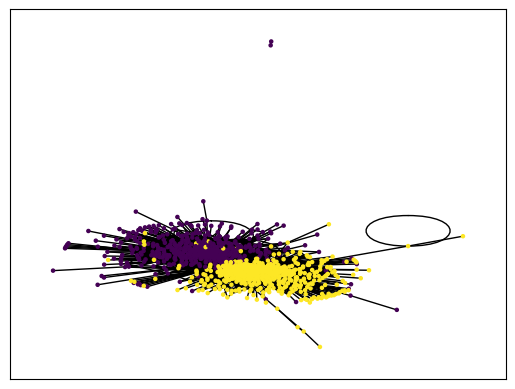

In [38]:
# Some basic plotting

nx.draw_networkx(
    polblogs["nx_graph"],
    with_labels=False,
    node_size=5,
    node_color=polblogs["labels"].reindex(polblogs["nx_graph"].nodes),
)

## Distortion and Mean average precision

**Mean average precision:** Let some node $a \in V$ have neighborhood $\mathcal{N}_a = \{b_1, b_2, \ldots, b_{deg(a)} \}$
where $a$ denotes the degree of $a$. Then we let $R_{a, b_i}$ mean the smallest set of nearest points required to retrieve the $i$-th neighbor of $a$ in our embedding space $f$. MAP is:
$$
\begin{align*}
MAP(f) &= \frac{1}{|V|} \sum_{a \in V} \frac{1}{|\mathcal{N}_a|} \sum_{i=1}^{|\mathcal{N}_a|} Precision(R_{a,b_i})\\
&= \frac{1}{|V|} \sum_{a \in V} \frac{1}{deg(a)} \sum_{i=1}^{|\mathcal{N}_a|} \frac{|\mathcal{N}_a \cap R_{a, b_i}|}{|R_{a,b_i}|}
\end{align*}
$$
Best case: $MAP(f) = 1$; not concerned with the underlying distances, only neighborhood membership.

**Distortion:** For an $n$ point embedding, the distortion is
$$
D(f) = \frac{1}{n \choose 2}\left( \frac{|d_V(f(u), f(v)) - d_U(u,v)|}{d_U(u,v)} \right)
$$

**Worst-case distortion**
$$
\begin{align}
D &= \left\{ \frac{d_V(f(u), f(v))}{d_U(u,v)} : u, v \in U, u \neq v \right\}\\
D_{wc}(f) &= \frac{\max(D)}{\min(D)}
\end{align}
$$

## Poincare embeddings (geomstats implementation)

First, we will ensure we can learn an embedding for polblogs using geomstats

INFO: Number of edges: 1224
INFO: Mean vertices by edges: 27.31454248366013


Number of nodes: 1224


INFO: iteration 0 loss_value 1.945955
INFO: iteration 1 loss_value 1.914547
INFO: iteration 2 loss_value 1.892975
INFO: iteration 3 loss_value 1.870823
INFO: iteration 4 loss_value 1.832022
INFO: iteration 5 loss_value 1.784688
INFO: iteration 6 loss_value 1.733318
INFO: iteration 7 loss_value 1.691309
INFO: iteration 8 loss_value 1.651277
INFO: iteration 9 loss_value 1.622606


Embedding shape: (1224, 2)


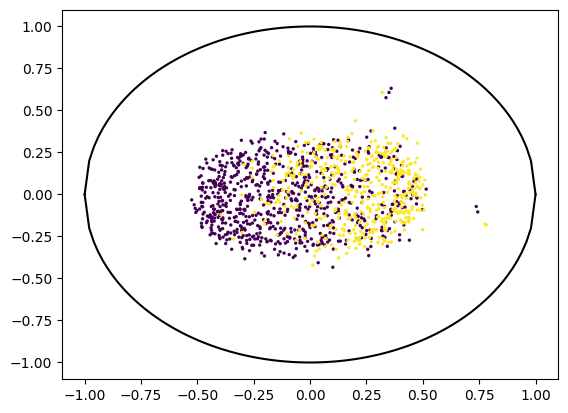

In [104]:
# # Filter
# gs_graph = deepcopy(polblogs["gs_graph"])
# keep = [k for k, v in gs_graph.edges.items() if len(v) > 2]
# gs_graph.edges = {k: v for k, v in gs_graph.edges.items() if k in keep}
# gs_graph.labels = {k: v for k, v in gs_graph.labels.items() if k in keep}
# gs_graph.n_nodes = len(keep)

# Embed - geomstats
print(f"Number of nodes: {polblogs['gs_graph'].n_nodes}")
# print(f"Number of nodes: {gs_graph.n_nodes}")
hyp_emb = HyperbolicEmbedding(
    dim=2, n_negative=10, n_context=10, lr=0.01, max_epochs=10
)
polblogs_gs_embed = hyp_emb.embed(polblogs["gs_graph"])
# polblogs_gs_embed = hyp_emb.embed(gs_graph)
print(f"Embedding shape: {polblogs_gs_embed.shape}")

# Plot embeddings
plt.scatter(
    polblogs_gs_embed[:, 0],
    polblogs_gs_embed[:, 1],
    c=polblogs["labels"].reindex(polblogs["gs_graph"].edges.keys()),
    s=2,
)
# Plot poincare disk
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
plt.show()

In [140]:
# Assess distortion

# Clip to max distance in embeddings
manifold = Hyperbolic(2, default_coords_type="ball")
pairwise_dists = squareform(
    pdist(polblogs_gs_embed, metric=manifold.metric.dist)
)
graph_dists = np.clip(
    polblogs["dists"], a_min=None, a_max=np.max(pairwise_dists)
)

# Assess distortion:
polblogs_gs_distortion = distortion(
    graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1
)
mc, me, avg, bad = polblogs_gs_distortion
polblogs_gs_map_score = map_score(
    graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1
)

print(f"Distortion: {avg}")
print(f"MAP score: {polblogs_gs_map_score}")

Distortion: 0.6366045827989886
MAP score: 0.030624119185722328


## Mixed-curvature embeddings (Hazy implementation)